# Quantum Circuit, Boolean Functions and Universality

#### 1.  Implement a Boolean Function
Let $f : \{0, 1\}^n \rightarrow \{0, 1\}$ be a Boolean function that takes $n$ bits as input.

We can build a reversible circuit $C_f$ that takes $n + 1$ input qubits (the first $n$ are input to $f$) and returns $n + 1$ output qubits (the first $n$ are identical with the first $n$ qubits of the input), where $C_f : |x, y \rangle \rightarrow |x, y \oplus f(x)\rangle$. 


<img src="Image/img.png" width=350 />



Let's consider $f: \{0, 1\}^3 \rightarrow \{0, 1\}$ such that $f(x,y,z) = \neg(x \wedge y) \wedge z $, build the circuit corresponding to $C_f$


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler
from qiskit.quantum_info import Operator
import numpy as np

sampler = Sampler()

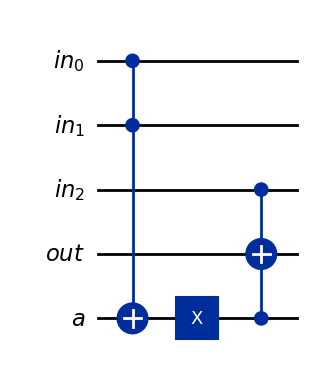

In [2]:

def quantum_3and_not():
    input = QuantumRegister(3, name='in')
    output = QuantumRegister(1, name='out')
    work = QuantumRegister(1, name='a')
    qc = QuantumCircuit(input, output, work, name='!(x&y)&z')
    qc.ccx(input[0],input[1],work)
    qc.x(work)
    qc.ccx(input[2],work,output)
    
    return  qc

test = quantum_3and_not()
test.draw('mpl')

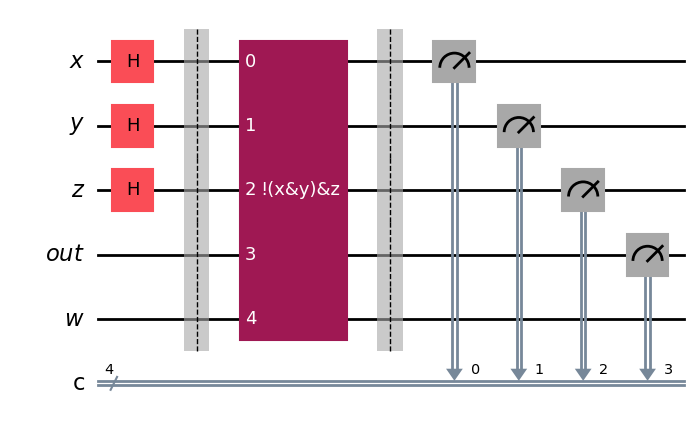

In [3]:

x,y,z = QuantumRegister(1, name='x'), QuantumRegister(1, name='y'), QuantumRegister(1, name='z')
w = QuantumRegister(1, name='w')
out = QuantumRegister(1, name='out')
c = ClassicalRegister(4,name='c')
qc = QuantumCircuit(x,y,z,out,w,c)

# initialize the circuit
qc.h(x[0])
qc.h(y[0])
qc.h(z[0])
qc.barrier()
qc.append(quantum_3and_not(),[x,y,z,out,w])
qc.barrier()

qc.measure(x[0],0)
qc.measure(y[0],1)
qc.measure(z[0],2)
qc.measure(out[0],3)

qc.decompose().draw('mpl')
qc.draw('mpl')

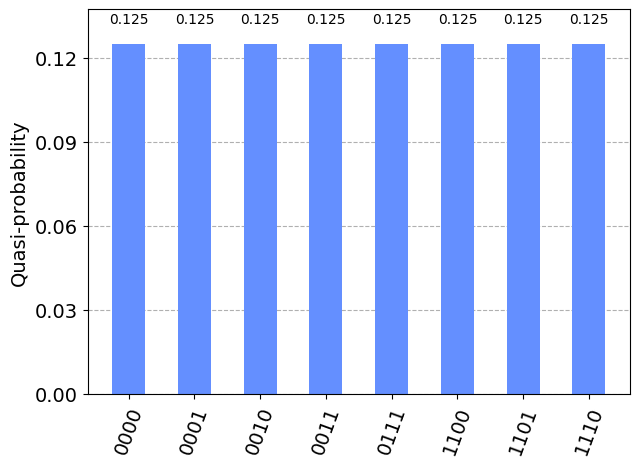

In [4]:

job = sampler.run(qc)
result = job.result()
plot_histogram(result.quasi_dists[0].binary_probabilities())

#### 2.  Reset Workspace Qubits

In the previous circuit we have used some extra workspace qubits.

In classical computing, we can discard redundant information to free up memory for other tasks without affecting results.  
In quantum computing, though, discarding correlated information can significantly alter computation results.
In fact, discard or overwrite a variable means measure it


In [5]:
# TODO verifies this on the previous exercise - F for Qiskit

We can see how the ancilla drop alter the result using composer: 
[Wrong ancilla drop](https://quantum.ibm.com/composer/files/new?initial=N4IgdghgtgpiBcIYA8AENIHMA2A6EANCAI4QDOUCIA8gAoCiAcgIoCCAygLKoBMuADAG4AOmACWYAMbYArgBMYqYSRjYxAIwCMuCZOUiwo4gCcYmVMQDaAVgC6ByafOTLm%2B6NEALC5f7uw3lZuBoGWPP6SkmhWfgQ%2BbnFWACz%2B0ZYpDlE%2B4YnptrkAzP7qEMbGYjDGFoKoAPS1qAACAA6e5DAAImJkANaisOQypj4pqAC0AHyoLn4GJWUVVcQ19U2t7V29ooQgCmSOYs0ALmIA9mBUIAC%2BQA)

##### Correct Ancilla Drop
To discard or reuse some qubits without side effects we need to reset their value, exploiting the reversible nature of quantum computation.
With boolean functions, this can be done automatically by the following circuit:

<img src="Image/img_1.png" width=500 />

The block labelled $C_f$ represents the function circuit. 
Then we copy the output $y = f(x)$ to another register. 
Finally, run the circuit for $C_f$ backwards (replacing each gate by its inverse gate) to erase the contents of the output and workspace registers.

Now implement the circuit in figure considering $C_f$ from the previous exercise

##### Hint
In qiskit `QuantumCircuit()` has the `.inverse()` methods to automatically compute the inverse of a circuit (i.e. to execute if backwards)

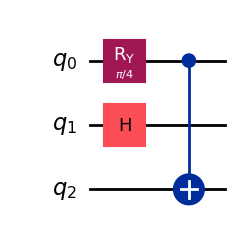

In [6]:
from math import pi

qc = QuantumCircuit(3)

qc.ry(pi/4,0)
qc.h(1)
qc.cx(0,2)
qc.draw('mpl')

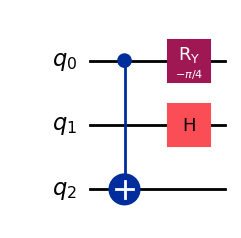

In [7]:
qc2 = qc.inverse()
qc2.draw('mpl')

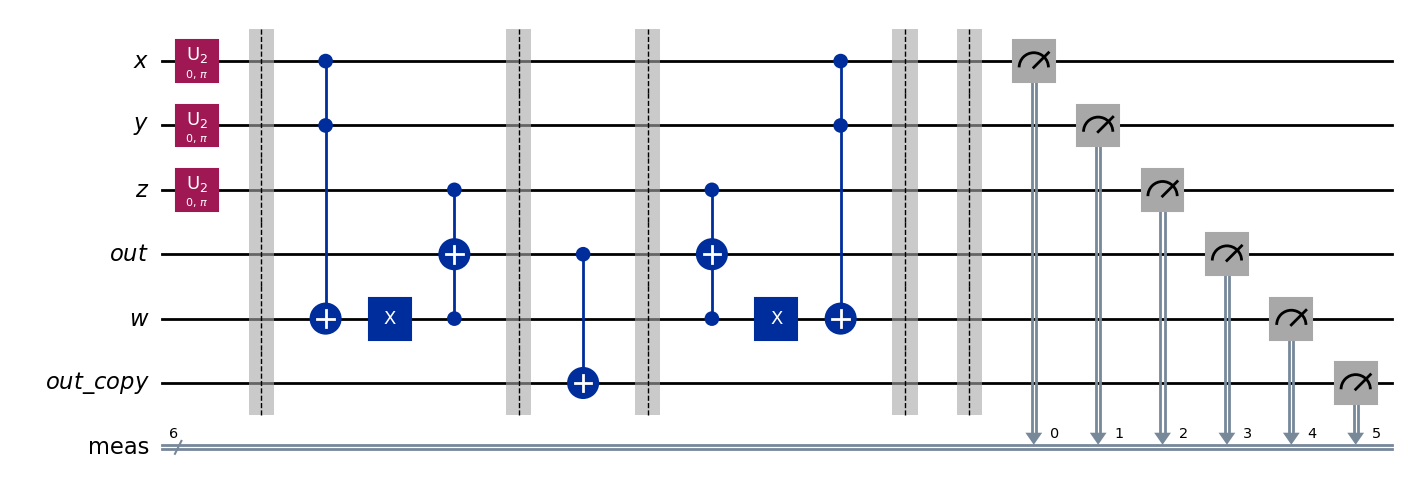

In [8]:

x,y,z = QuantumRegister(1, name='x'), QuantumRegister(1, name='y'), QuantumRegister(1, name='z')
w = QuantumRegister(1, name='w')
out = QuantumRegister(1, name='out')
out_copy = QuantumRegister(1, name='out_copy')
# c = ClassicalRegister(4,name='c')
qc = QuantumCircuit(x,y,z,out,w,out_copy)

# initialize the circuit
qc.h(x[0])
qc.h(y[0])
qc.h(z[0])
qc.barrier()
qc.append(quantum_3and_not(),[x,y,z,out,w])
qc.barrier()
qc.cx(out[0], out_copy[0])
qc.barrier()
qc.append(quantum_3and_not().inverse(),[x,y,z,out,w])
qc.barrier()
qc.measure_all()
# qc.measure(out[0],3)

qc.decompose().draw('mpl')
# qc.draw('mpl')


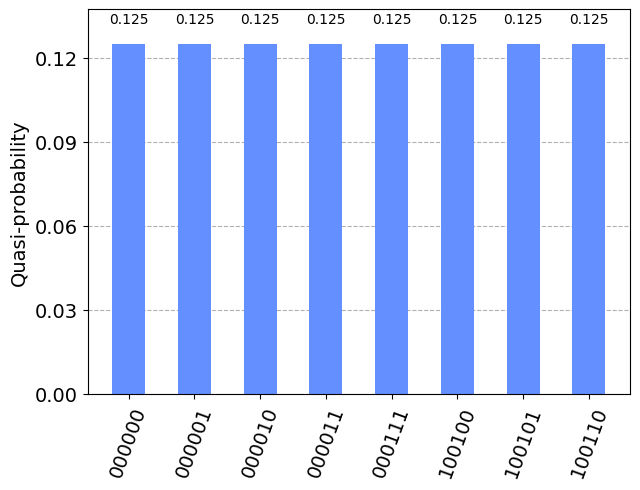

In [9]:

job = sampler.run(qc)
result = job.result()
plot_histogram(result.quasi_dists[0].binary_probabilities())

#### 3. Rotation Gates

The exponential of the Pauli matrices gives rise to three classes of unitary matrices, namely the rotation operators about the $x$, $y$, and $z$ axes, defined by:

$$
R_x(θ) ≡ e^{-iθσ_x/2} = cos(θ/2)I - isin(θ/2)σ_x = \begin{bmatrix} cos(θ/2) & -isin(θ/2)\\
                                                                   -isin(θ/2) & cos(θ/2) \end{bmatrix}                                                  
$$



$$
R_y(θ) ≡ e^{-iθσ_y/2} = cos(θ/2)I - isin(θ/2)σ_y = \begin{bmatrix} cos(θ/2) & -sin(θ/2)\\
                                                                    sin(θ/2) & cos(θ/2) \end{bmatrix}
$$

$$
R_z(θ) ≡ e^{-iθσ_z/2} = cos(θ/2)I - isin(θ/2)σ_z = \begin{bmatrix} e^{-iθ/2} & 0 \\
                                                                   0 & e^{iθ/2}  \end{bmatrix}
$$

Show that the Hadamard gate $H$ can be expressed as a product of $R_x$ and $R_z$ and $e^{i\phi}$ for some $\phi$.

Let's try to rotate by $\pi/2$ on X and Z:

In [10]:
c = QuantumCircuit(1)

c.rx(pi/2,0)
c.rz(pi/2,0)

Operator(c)
# Statevector(c)

Operator([[ 0.5-0.5j, -0.5-0.5j],
          [ 0.5-0.5j,  0.5+0.5j]],
         input_dims=(2,), output_dims=(2,))


There is something different, infact:
$$
R_z(\pi/2) \cdot R_x(\pi/2) = \begin{bmatrix}
e^\left(-i*\left(\pi/4\right)\right) & 0 \\
0 & e^\left(i*\left(\pi/4\right)\right)
\end{bmatrix}
\cdot
\begin{bmatrix}
\cos\left(\frac{\pi}{4}\right) & -i*\sin\left(\frac{\pi}{4}\right) \\
-i*\sin\left(\frac{\pi}{4}\right) & \cos\left(\frac{\pi}{4}\right)
\end{bmatrix} =
$$
$$
= \begin{bmatrix}
\frac{\left(1-i\right)*\sqrt{2}}{2} & 0 \\
0 & \frac{\left(1+i\right)*\sqrt{2}}{2}
\end{bmatrix}
\cdot
\begin{bmatrix}
\frac{\sqrt{2}}{2} & \frac{-i*\sqrt{2}}{2} \\
\frac{-i*\sqrt{2}}{2} & \frac{\sqrt{2}}{2}
\end{bmatrix} =
$$
$$
= \begin{bmatrix}
\frac{1-i}{2} & -\frac{1+i}{2} \\
\frac{1-i}{2} & \frac{1+i}{2}
\end{bmatrix}\\
$$

\
Let's consider the first column, we want that $\frac{1-i}{2}$ becomes $\frac{\sqrt{2}}{2}$, so we need to find a $x$, such that 
$$
x \cdot \frac{1-i}{2} = \frac{\sqrt{2}}{2} \rightarrow x = \frac{\sqrt{2}}{1-i}
$$
We do some manipulation to see this result in a nicer form:
$$
\frac{\sqrt{2}}{1-i}*\frac{i-1}{1-i} = \frac{\sqrt{2}(1-i)}{(1-i)^2} = \frac{\sqrt{2}-\sqrt{2}i}{-2i} = \frac{\sqrt{2}i}{2i}-\frac{\sqrt2}{2i} = \frac{\sqrt{2}}{2} + \frac{\sqrt{2}(-1)}{2\sqrt{(-1)}} = \frac{\sqrt{2}}{2} + \frac{\sqrt{2}i}{2}
$$
Let's recall the Euler formula: $e^{-iθ/2} = cos(θ/2) - isin(θ/2)$.
If we choose $θ = -\pi/2$, then  $e^{i\pi/4} = \frac{\sqrt{2}}{2} + \frac{\sqrt{2}i}{2}$

Similarly, let's consider the second column; we want that $\frac{1-i}{2}$ becomes $-\frac{\sqrt{2}}{2}$.
$$
x \cdot \frac{1+i}{2} = -\frac{\sqrt{2}}{2} \rightarrow 
x = - \frac{\sqrt{2}}{1+i} = -(\frac{\sqrt{2}}{2} - \frac{\sqrt{2}i}{2})
$$

If we choose $θ = \pi/2$, then  $e^{-i\pi/4} = \frac{\sqrt{2}}{2} - \frac{\sqrt{2}i}{2}$

Now, what we want is:
$$
\begin{bmatrix}
e^{i\pi/4} \cdot \frac{1-i}{2} & -e^{-i\pi/4} \cdot-\frac{1+i}{2} \\
e^{i\pi/4} \cdot \frac{1-i}{2} & -e^{-i\pi/4} \cdot \frac{1+i}{2}
\end{bmatrix} =
\begin{bmatrix}
\frac{1-i}{2} & -\frac{1+i}{2} \\
\frac{1-i}{2} & \frac{1+i}{2}
\end{bmatrix} \cdot
\begin{bmatrix}
e^{i\pi/4} & 0\\
0 & -e^{-i\pi/4}
\end{bmatrix} = 
$$
$$
= \begin{bmatrix}
\frac{1-i}{2} & -\frac{1+i}{2} \\
\frac{1-i}{2} & \frac{1+i}{2}
\end{bmatrix} \cdot
\begin{bmatrix}
e^{i\pi/4} & 0\\
0 & e^{-i\pi/4}
\end{bmatrix} \cdot
\begin{bmatrix}
1 & 0\\
0 & -1
\end{bmatrix} =
$$
$$
= R_z(\pi/2) \cdot R_x(\pi/2) \cdot R_z(-\pi/2) \cdot 
\begin{bmatrix}
1 & 0\\
0 & -1
\end{bmatrix} =
$$

We can also verify this on qiskit:

In [15]:
c = QuantumCircuit(1)
o = Operator(np.array([[1,0],[0,-1]]))

c.append(o,[0])
c.rz(-pi/2,0)
c.rx(pi/2,0)
c.rz(pi/2,0)

Operator(c)

Operator([[ 0.70710678+0.j,  0.70710678+0.j],
          [ 0.70710678+0.j, -0.70710678+0.j]],
         input_dims=(2,), output_dims=(2,))


We need to express the $[[1,0][0,-1]]$ only using $R_z$, $R_x$ and global phases. 
You should know that $[[1,0][0,-1]]$ is the Pauli operator $σ_z$  that corresponds to a rotation of $\pi$ radians with respect to the $Z$ axis.
If we compute $R_z(\pi)$ we note that:
$$R_z(\pi) = \begin{bmatrix} -i & 0 \\ 0 & i \end{bmatrix}$$

So we need a global phase $i$, such that $i*(-i) = 1$ and $i*i = -1$, and in particular, $e^{i\phi} = i$ when $\phi = \pi/2$.
So finally, we have:
$$
R_z(\pi/2) \cdot R_x(\pi/2) \cdot R_z(-\pi/2) \cdot R_z(\pi) \cdot e^{i\pi/2} = R_z(\pi/2) \cdot R_x(\pi/2) \cdot R_z(\pi/2) \cdot e^{i\pi/2}.
$$

We can verify this result on qiskit:

In [42]:
from qiskit.circuit.library import GlobalPhaseGate

c = QuantumCircuit(1)

c.append(GlobalPhaseGate(pi/2))
c.rz(pi/2,0)
c.rx(pi/2,0)
c.rz(pi/2,0)

Operator(c)

Operator([[ 0.70710678+0.j,  0.70710678+0.j],
          [ 0.70710678+0.j, -0.70710678+0.j]],
         input_dims=(2,), output_dims=(2,))


#### 4. Universality
##### 1
 
If for a single qubit unitary operation $U$ we have $U = V^2$ where V is another single qubit unitary operation, then the double controlled $U$ gate, called $CCU$ gate, can be implemented as: 

<img src="Image/img_2.png" width=600 />


Show that for $V = (1 — i)(I + iX)/2$, $CCU$ implements the Toffoli gate.


We can use `Pauli` object to instantiate Pauli operator matrices

In [43]:

from qiskit.quantum_info import Pauli

X = Operator(Pauli('X'))
print(X)
I = Operator(Pauli('I'))
print(I)

Operator([[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))
Operator([[1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j]],
         input_dims=(2,), output_dims=(2,))


In [ ]:
# We compute V
i = 1j
V = ((1-1j)*(I + i*X))/2
V

In [46]:
a = Operator(V)
c = QuantumCircuit(1, name='V')
c.append(a,[0])
# this makes the circuit a controlled operator
op = c.to_gate().control(1)

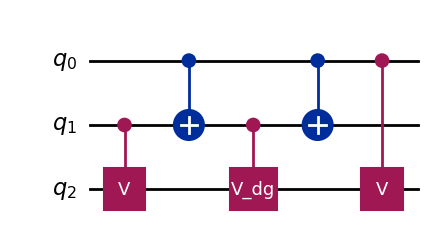

In [76]:
toff = QuantumCircuit(3,name='toffoli')
toff.append(op,[1,2])
toff.cx(0,1)
toff.append(op.inverse(),[1,2])
toff.cx(0,1)
toff.append(op,[0,2])
toff.draw('mpl')

We can test the results

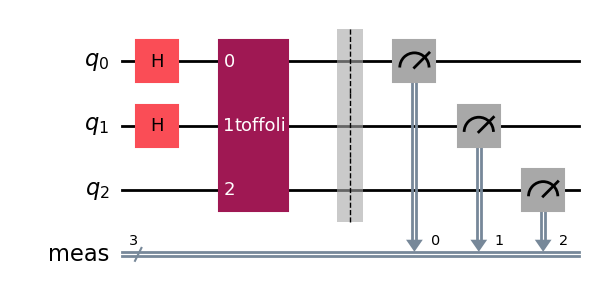

In [78]:
test = QuantumCircuit(3)

# convert toff to a gate
toff.to_gate()

# initialize the first two qubit, so we can test all inputs
test.h(0)
test.h(1)

test.append(toff,[0,1,2])
test.measure_all()
test.draw('mpl')

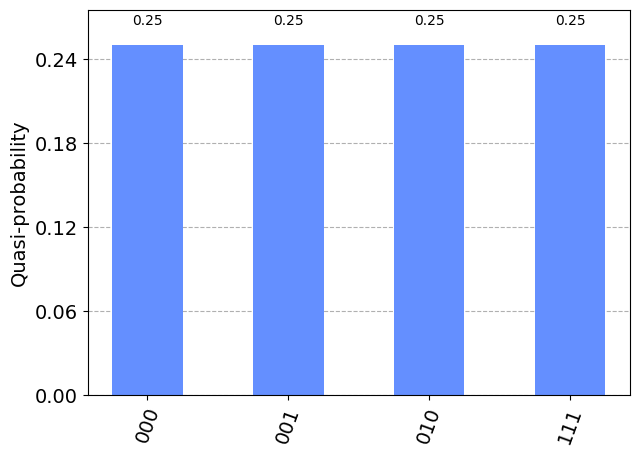

In [79]:
job = sampler.run(test)
result = job.result()
plot_histogram(result.quasi_dists[0].binary_probabilities())


##### 2 
Check that:
1. $XYX = —Y$ and $XZX = —Z$;  

In [80]:

X = Operator(Pauli('X'))
Y = Operator(Pauli('Y'))
# np.dot(np.dot(X,Y),X)
X @ Y @ X

Operator([[0.+0.j, 0.+1.j],
          [0.-1.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))


In [81]:
Z = Operator(Pauli('Z'))
# np.dot(np.dot(X,Y),X)
X @ Z @ X

Operator([[-1.+0.j,  0.+0.j],
          [ 0.+0.j,  1.+0.j]],
         input_dims=(2,), output_dims=(2,))


2. $XR_y(θ)X = R_y(-θ)$ and $XR_z(θ)X = R_z(-θ)$. 



In [98]:
from qiskit.circuit.library import RYGate

theta = pi/4
print(Operator(RYGate(-theta)))
Ry = Operator(RYGate(theta))

X @ Ry @ X

Operator([[ 0.92387953+0.j,  0.38268343+0.j],
          [-0.38268343+0.j,  0.92387953+0.j]],
         input_dims=(2,), output_dims=(2,))
Operator([[ 0.92387953+0.j,  0.38268343+0.j],
          [-0.38268343+0.j,  0.92387953+0.j]],
         input_dims=(2,), output_dims=(2,))


In [97]:
from qiskit.circuit.library import RZGate

theta = pi/3
print(Operator(RZGate(-theta)))
Rz = Operator(RZGate(theta))

X @ Rz @ X

Operator([[0.8660254+0.5j, 0.       +0.j ],
          [0.       +0.j , 0.8660254-0.5j]],
         input_dims=(2,), output_dims=(2,))
Operator([[0.8660254+0.5j, 0.       +0.j ],
          [0.       +0.j , 0.8660254-0.5j]],
         input_dims=(2,), output_dims=(2,))
